In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

In [6]:
mnist_data = datasets.MNIST('./mnist_data', train=True, download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor()
                           ]))

In [24]:
mnist_data[3][0].shape

torch.Size([1, 28, 28])

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)        
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [20]:
data = [d[0].data.cpu().numpy() for d in mnist_data]

In [21]:
np.mean(data)

0.13066062

In [22]:
np.std(data)

0.30810776

In [29]:
def train(model, device, train_dataloader, optimizer, epoch):
    model.train()
    for idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        pred = model(data)
        loss = F.nll_loss(pred, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if idx % 100 == 0:
            print(epoch, idx, loss.item())

In [33]:
def test(model, device, test_dataloader):
    model.eval()
    total_loss = 0.
    correct = 0.
    with torch.no_grad():
        for idx, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    total_loss /= len(test_dataloader.dataset)
    acc = correct / len(test_dataloader.dataset) * 100
    print(total_loss, acc)

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist_data', train=True, download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                           ])),
    batch_size = batch_size, shuffle=True, num_workers=1, pin_memory=True
)
test_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist_data', train=True, download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                           ])),
    batch_size = batch_size, shuffle=True, num_workers=1, pin_memory=True
)
lr = 0.01
momentum = 0.5
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

num_epochs = 2
for epoch in range(num_epochs):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

torch.save(model.state_dict(), 'mnist_cnn.pt')

0 0 2.3120169639587402
0 100 0.5160195231437683
0 200 0.27801305055618286
0 300 0.32141339778900146
0 400 0.06408755481243134
0 500 0.04280734062194824
0 600 0.10039804875850677
0 700 0.11163090169429779
0 800 0.0798773467540741
0 900 0.22488166391849518
0 1000 0.12763628363609314
0 1100 0.16045799851417542
0 1200 0.05587790906429291
0 1300 0.02396915853023529
0 1400 0.06803074479103088
0 1500 0.021201446652412415
0 1600 0.09555266797542572
0 1700 0.09806959331035614
0 1800 0.21140432357788086
0.07819252621730169 97.51833333333333
1 0 0.03177158534526825
1 100 0.3009430468082428
1 200 0.011692121624946594
1 300 0.02375142276287079
1 400 0.019828200340270996
1 500 0.018467575311660767
1 600 0.008339360356330872
1 700 0.017592906951904297
1 800 0.05481243133544922
1 900 0.29156163334846497
1 1000 0.04300718009471893
1 1100 0.031570062041282654
1 1200 0.0782526433467865
1 1300 0.006319284439086914
1 1400 0.00038751959800720215
1 1500 0.0037681609392166138
1 1600 0.1274586319923401
1 1700 

In [39]:
data_dir = "./hymenoptera_data"
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"
# Number of classes in the dataset
num_classes = 2
# Batch size for training (change depending on how much memory you have)
batch_size = 32
# Number of epochs to train for 
num_epochs = 15
# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

input_size = 224

In [40]:
all_imgs = datasets.ImageFolder(os.path.join(data_dir, "train"), transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]))
loader = torch.utils.data.DataLoader(all_imgs, batch_size=batch_size, shuffle=True, num_workers=4)

In [54]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ["train", "val"]}

dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], 
        batch_size=batch_size, shuffle=True, num_workers=4) for x in ["train", "val"]}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [55]:
# img = next(iter(loader))[0]
img = next(iter(dataloaders_dict['val']))[0]

In [56]:
img.shape

torch.Size([32, 3, 224, 224])

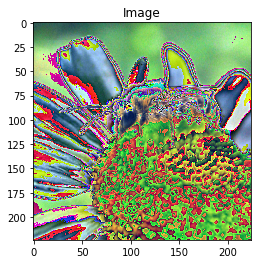

In [57]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(img[2], title='Image')

In [50]:
def set_parameter_requires_grad(model, feature_extract):
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False
            
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    if model_name == "resnet":
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    else:
        print("model not implemented")
        return None, None
        
    return model_ft, input_size

model_ft, input_size = initialize_model(model_name, 
                    num_classes, feature_extract, use_pretrained=True)
print(model_ft)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\Administrator/.cache\torch\checkpoints\resnet18-5c106cde.pth

  0%|                                              | 0.00/44.7M [00:00<?, ?B/s]
  0%|                                      | 24.0k/44.7M [00:00<07:15, 107kB/s]
  0%|                                      | 56.0k/44.7M [00:00<06:08, 127kB/s]
  0%|                                      | 80.0k/44.7M [00:00<05:35, 139kB/s]
  0%|                                       | 112k/44.7M [00:00<04:47, 162kB/s]
  0%|▏                                      | 152k/44.7M [00:00<04:04, 191kB/s]
  0%|▏                                      | 224k/44.7M [00:00<03:12, 242kB/s]
  1%|▏                                      | 288k/44.7M [00:00<02:36, 297kB/s]
  1%|▎                                      | 368k/44.7M [00:01<02:07, 365kB/s]
  1%|▍                                      | 488k/44.7M [00:01<01:40, 462kB/s]
  1%|▌                                      | 632k/44

 91%|█████████████████████████████████▋   | 40.6M/44.7M [00:11<00:01, 4.01MB/s]
 92%|█████████████████████████████████▉   | 41.0M/44.7M [00:11<00:00, 3.98MB/s]
 93%|██████████████████████████████████▎  | 41.4M/44.7M [00:11<00:00, 3.96MB/s]
 94%|██████████████████████████████████▌  | 41.8M/44.7M [00:11<00:00, 3.92MB/s]
 94%|██████████████████████████████████▉  | 42.2M/44.7M [00:11<00:00, 3.92MB/s]
 95%|███████████████████████████████████▏ | 42.5M/44.7M [00:11<00:00, 3.94MB/s]
 96%|███████████████████████████████████▌ | 42.9M/44.7M [00:11<00:00, 3.92MB/s]
 97%|███████████████████████████████████▊ | 43.3M/44.7M [00:11<00:00, 3.91MB/s]
 98%|████████████████████████████████████▏| 43.7M/44.7M [00:11<00:00, 3.91MB/s]
 99%|████████████████████████████████████▌| 44.1M/44.7M [00:12<00:00, 3.92MB/s]
100%|████████████████████████████████████▊| 44.5M/44.7M [00:12<00:00, 3.92MB/s]
100%|█████████████████████████████████████| 44.7M/44.7M [00:12<00:00, 3.85MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [51]:
model_ft.layer1[0].conv1.weight.requires_grad

False

In [52]:
model_ft.fc.weight.requires_grad

True

In [58]:
def train_model(model, dataloaders, loss_fn, optimizer, num_epochs=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.
    val_acc_history = []
    for epoch in range(num_epochs):
        for phase in ["train", "val"]:
            running_loss = 0.
            running_corrects = 0.
            if phase == "train":
                model.train()
            else:
                model.eval()
                
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                
                with torch.autograd.set_grad_enabled(phase=="train"):
                    outputs = model(inputs) # bsize * 2
                    loss = loss_fn(outputs, labels) 
                    
                preds = outputs.argmax(dim=1)
                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds.view(-1) == labels.view(-1)).item()
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            
            print("Phase {} loss: {}, acc: {}".format(phase, epoch_loss, epoch_acc))
            
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "val":
                val_acc_history.append(epoch_acc)
    model.load_state_dict(best_model_wts)    
    return model, val_acc_history

In [59]:
model_ft = model_ft.to(device)

In [60]:
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, 
                                   model_ft.parameters()), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

In [61]:
_, ohist = train_model(model_ft, dataloaders_dict, loss_fn, optimizer, num_epochs=num_epochs)

Phase train loss: 0.7903101385616865, acc: 0.45901639344262296
Phase val loss: 0.5993359252518299, acc: 0.6862745098039216
Phase train loss: 0.5655224762979101, acc: 0.7213114754098361
Phase val loss: 0.42627663725341847, acc: 0.8954248366013072
Phase train loss: 0.4472130195039218, acc: 0.7991803278688525
Phase val loss: 0.3223634192756578, acc: 0.9215686274509803
Phase train loss: 0.3353370081205837, acc: 0.8852459016393442
Phase val loss: 0.2771838294719559, acc: 0.934640522875817
Phase train loss: 0.2915488154184623, acc: 0.889344262295082
Phase val loss: 0.2446523949601292, acc: 0.9411764705882353
Phase train loss: 0.2710560462513908, acc: 0.9098360655737705
Phase val loss: 0.2514406715343201, acc: 0.9215686274509803
Phase train loss: 0.22920502746691468, acc: 0.9426229508196722
Phase val loss: 0.22450738931013867, acc: 0.934640522875817


KeyboardInterrupt: 

In [62]:
model_scratch, _ = initialize_model(model_name, 
                    num_classes, feature_extract=False, use_pretrained=False)
model_scratch = model_scratch.to(device)
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, 
                                   model_scratch.parameters()), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
_, scratch_hist = train_model(model_scratch, dataloaders_dict, loss_fn, optimizer, num_epochs=num_epochs)

Phase train loss: 0.7037546996210442, acc: 0.5040983606557377
Phase val loss: 0.6803008181596893, acc: 0.5424836601307189
Phase train loss: 0.6904646666323553, acc: 0.5245901639344263
Phase val loss: 0.6925302369921815, acc: 0.5294117647058824


KeyboardInterrupt: 

NameError: name 'ohist' is not defined

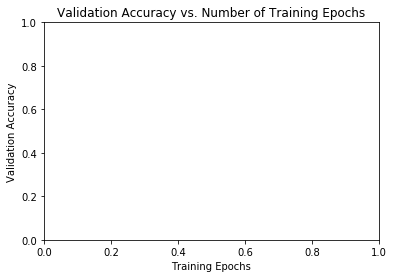

In [ ]:

# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),scratch_hist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()